In [3]:
import pandas as pd
import numpy as np
import csv
import json
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import make_blobs
from scipy.spatial.distance import cdist
from scipy.sparse import csc_matrix

In [4]:
# read csv
df = pd.read_csv("../hate-speech-detection-using-chatgpt/csv/labeled_data_preprocessed_without_url.csv")

labels = [0, 1, 2]
columns = df.columns

# train-test split (7:3)

In [5]:
idx_train, idx_test = train_test_split(df.index.values, test_size=0.30, random_state=624)
train_df = df.iloc[idx_train]
test_df = df.iloc[idx_test]

In [6]:
test_df.to_csv("../hate-speech-detection-using-chatgpt/csv/labeled_data_preprocessed_without_url_test.csv", index=False)

# just split

In [7]:
train_sample_df = pd.DataFrame([], columns=columns)

In [8]:
for label in labels:
    tmp = train_df[train_df['class'] == label]
    tmp_sampled = tmp.sample(frac=1).iloc[:100]
    train_sample_df = pd.concat([train_sample_df, tmp_sampled])

In [9]:
train_sample_df.loc[train_sample_df['class'] == 0, 'class'] = 'hate'
train_sample_df.loc[train_sample_df['class'] == 1, 'class'] = 'offensive'
train_sample_df.loc[train_sample_df['class'] == 2, 'class'] = 'neutral'

In [10]:
train_sample_df = train_sample_df.sample(frac=1)

In [11]:
json_data = []
for i in range(len(train_sample_df)):
    json_data.append({"prompt": f"{train_sample_df.iloc[i]['tweet']}", "completion": train_sample_df.iloc[i]['class']})

In [12]:
with open("../hate-speech-detection-using-chatgpt/csv/hate_speech_for_fine_tuning_without_url_train.jsonl" , encoding= "utf-8",mode="w") as file: 
    for i in json_data:
        file.write(json.dumps(i) + "\n")

# Find optimal K

In [58]:
def visualize_elbowmethod(data):
    distortions = []
    for i in range(5, 101, 5):
        km = KMeans(n_clusters=i, random_state=1)
        km.fit(data)
        distortions.append(km.inertia_)

    plt.plot(range(5, 101, 5), distortions, marker='o')
    plt.xlabel('Number of Cluster')
    plt.ylabel('Distortion')
    plt.show()

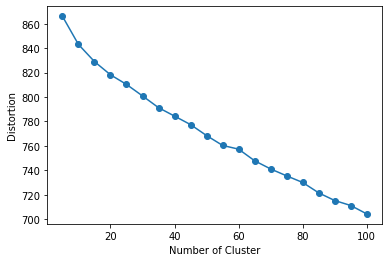

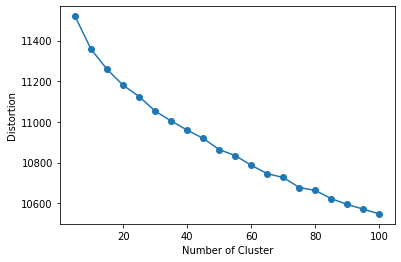

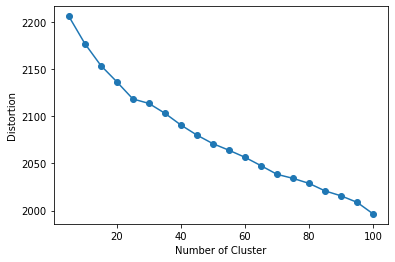

In [60]:
for label in labels:
    now_train_df = train_df[train_df['class'] == label]
    now_train_df.columns = ['label', 'tweet']
    train_label, train_tweet = list(now_train_df.label.values), list(now_train_df.tweet.values)
    X = vect.fit_transform(train_tweet)
    visualize_elbowmethod(X)

# k-means clustering (for each label)

In [196]:
def tfidf_clustering(k, nearest):
    train_sample_df = pd.DataFrame([], columns=columns)
    vect = TfidfVectorizer()  

    for label in labels:
        now_train_df = train_df[train_df['class'] == label]
        now_train_df.columns = ['label', 'tweet']
        train_label, train_tweet = list(now_train_df.label.values), list(now_train_df.tweet.values)
        
        X = vect.fit_transform(train_tweet)
        random_state = 1
        kmeans = KMeans(n_clusters=k, random_state = random_state).fit(X)

        closest_points = []
        dup = set()
        result = []
        i = 0
        for i in range(k):
            cluster_indices = np.where(kmeans.labels_ == i)[0]
            cluster_center = kmeans.cluster_centers_[i]
            distances = np.linalg.norm(X[cluster_indices] - cluster_center, axis=1)
            count = 0
            
            # remove duplicates
            for j in cluster_indices[np.argsort(distances)]:
                if train_tweet[j] not in dup:
                    closest_points.append(j)
                    dup.add(train_tweet[j])
                    count += 1
                if count == nearest:
                    break
        
        for j in closest_points:
            result.append([train_label[j], train_tweet[j]])
        
        cluster_df = pd.DataFrame(result, columns=columns)
        train_sample_df = pd.concat([train_sample_df, cluster_df])
            
        # print result
#         for i, index in enumerate(closest_points):
#             print(f"Cluster {i // 3 + 1}, Closest Point {i % 3 + 1} = {train_tweet[index]}")
#         print('===========================================================================')

    train_sample_df.loc[train_sample_df['class'] == 0, 'class'] = 'hate'
    train_sample_df.loc[train_sample_df['class'] == 1, 'class'] = 'offensive'
    train_sample_df.loc[train_sample_df['class'] == 2, 'class'] = 'neutral'
    train_sample_df = train_sample_df.sample(frac=1)
    
    json_data = []
    for i in range(len(train_sample_df)):
        json_data.append({"prompt": f"{train_sample_df.iloc[i]['tweet']}", "completion": train_sample_df.iloc[i]['class']})
        
    with open(f"../hate-speech-detection-using-chatgpt/csv/hate_speech_for_fine_tuning_without_url_train_{k}_clustering.jsonl" , encoding= "utf-8",mode="w") as file: 
        for i in json_data:
            file.write(json.dumps(i) + "\n")

In [198]:
tfidf_clustering(20, 3)

# k-means clustering (all together)

In [38]:
def tfidf_clustering_all(k, nearest):
    train_sample_df = pd.DataFrame([], columns=['class', 'tweet'])
    vect = TfidfVectorizer()
    train_df.columns = ['label', 'tweet']
    train_label, train_tweet = list(train_df.label.values), list(train_df.tweet.values)
    X = vect.fit_transform(train_tweet)
    random_state = 1
    kmeans = KMeans(n_clusters=k, random_state = random_state).fit(X)
    
    for i in range(k):
        closest_points = []
        cluster_indices = np.where(kmeans.labels_ == i)[0]
        cluster_center = kmeans.cluster_centers_[i]
        distances = np.linalg.norm(X[cluster_indices] - cluster_center, axis=1)
        
        for l in labels:
            for j in cluster_indices[np.argsort(distances)]:
                if train_label[j] == l:
                    closest_points.append([train_label[j], train_tweet[j]])
                    break
        
        cluster_df = pd.DataFrame(closest_points, columns=columns)
        train_sample_df = pd.concat([train_sample_df, cluster_df])
        
    train_sample_df.loc[train_sample_df['class'] == 0, 'class'] = 'hate'
    train_sample_df.loc[train_sample_df['class'] == 1, 'class'] = 'offensive'
    train_sample_df.loc[train_sample_df['class'] == 2, 'class'] = 'neutral'
    print(train_sample_df['class'].value_counts())
    train_sample_df = train_sample_df.sample(frac=1)
    
    json_data = []
    for i in range(len(train_sample_df)):
        json_data.append({"prompt": f"{train_sample_df.iloc[i]['tweet']}", "completion": train_sample_df.iloc[i]['class']})
        
    with open(f"../hate-speech-detection-using-chatgpt/csv/hate_speech_for_fine_tuning_without_url_train_{k}_clustering_all.jsonl" , encoding= "utf-8",mode="w") as file: 
        for i in json_data:
            file.write(json.dumps(i) + "\n")

In [39]:
tfidf_clustering_all(20, 1)

hate         20
offensive    20
neutral      17
Name: class, dtype: int64


In [40]:
tfidf_clustering_all(50, 1)

offensive    50
hate         48
neutral      42
Name: class, dtype: int64


In [41]:
tfidf_clustering_all(100, 1)

offensive    100
hate          93
neutral       83
Name: class, dtype: int64
